In [47]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import pandas as pd

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import FuncFormatter
%config InlineBackend.figure_format='retina'

In [49]:
pd.set_option('display.max_rows',100)

## Predict_date is one of input

In [72]:
predict_date='2018_12_20'

## find 15 previous days of week

In [73]:
num_day=30

In [74]:
predict_day=int(predict_date[8:])
predict_month=int(predict_date[5:7])
predict_year=int(predict_date[0:4])

In [75]:
str(predict_year)+'_'+str(predict_month)+'_'+str(predict_day)

'2018_12_21'

In [76]:
daybefore=[]
pmb=predict_month-1
dayleft=num_day-predict_day

## DO DAYOFWEEK BEFORE

In [77]:
updateday=predict_day
for i in range(num_day):
    if updateday>7:
        updateday -= 7
        daybefore.append(str(predict_year)+'_'+str(pmb+1).zfill(2)+'_'+str(updateday).zfill(2))
    else:
        if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
            updateday=31-7+updateday
            pmb -=1
            daybefore.append(str(predict_year)+'_'+str(pmb+1).zfill(2)+'_'+str(updateday).zfill(2))
        elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
            updateday=30-7+updateday
            pmb-=1
            daybefore.append(str(predict_year)+'_'+str(pmb+1).zfill(2)+'_'+str(updateday).zfill(2))
        else :
            if predict_year%4==0:
                updateday=29-7+updateday
                pmb-=1
                daybefore.append(str(predict_year)+'_'+str(pmb+1).zfill(2)+'_'+str(updateday).zfill(2))
            else:
                updateday=28-7+updateday
                pmb-=1
                daybefore.append(str(predict_year)+'_'+str(pmb+1).zfill(2)+'_'+str(updateday).zfill(2))

In [78]:
daybefore

['2018_12_14',
 '2018_12_07',
 '2018_11_30',
 '2018_11_23',
 '2018_11_16',
 '2018_11_09',
 '2018_11_02',
 '2018_10_26',
 '2018_10_19',
 '2018_10_12',
 '2018_10_05',
 '2018_09_28',
 '2018_09_21',
 '2018_09_14',
 '2018_09_07',
 '2018_08_31',
 '2018_08_24',
 '2018_08_17',
 '2018_08_10',
 '2018_08_03',
 '2018_07_27',
 '2018_07_20',
 '2018_07_13',
 '2018_07_06',
 '2018_06_29',
 '2018_06_22',
 '2018_06_15',
 '2018_06_08',
 '2018_06_01',
 '2018_05_25']

## Have daybefore

In [79]:
pathlist=[]
for i in reversed(daybefore):
    pathlist.append('Energy_Balance_'+str(i))
pathlist

['Energy_Balance_2018_05_25',
 'Energy_Balance_2018_06_01',
 'Energy_Balance_2018_06_08',
 'Energy_Balance_2018_06_15',
 'Energy_Balance_2018_06_22',
 'Energy_Balance_2018_06_29',
 'Energy_Balance_2018_07_06',
 'Energy_Balance_2018_07_13',
 'Energy_Balance_2018_07_20',
 'Energy_Balance_2018_07_27',
 'Energy_Balance_2018_08_03',
 'Energy_Balance_2018_08_10',
 'Energy_Balance_2018_08_17',
 'Energy_Balance_2018_08_24',
 'Energy_Balance_2018_08_31',
 'Energy_Balance_2018_09_07',
 'Energy_Balance_2018_09_14',
 'Energy_Balance_2018_09_21',
 'Energy_Balance_2018_09_28',
 'Energy_Balance_2018_10_05',
 'Energy_Balance_2018_10_12',
 'Energy_Balance_2018_10_19',
 'Energy_Balance_2018_10_26',
 'Energy_Balance_2018_11_02',
 'Energy_Balance_2018_11_09',
 'Energy_Balance_2018_11_16',
 'Energy_Balance_2018_11_23',
 'Energy_Balance_2018_11_30',
 'Energy_Balance_2018_12_07',
 'Energy_Balance_2018_12_14']

In [80]:
def clean(path):
    rawdata=pd.read_csv(path+".csv", delimiter=";" )
    deleteindex=rawdata.loc[rawdata.loc[pd.IndexSlice[:,'Battery discharging / Mean values [W] ']]==' '].index
    rawdata.drop(deleteindex,inplace=True)
    rawdata.rename(columns={' ':'Time'},inplace=True)
    rawdata['Time']=rawdata['Time'].str.replace('[^\d]','')
    rawdata['Time']=path[15:19]+path[20:22]+path[23:]+rawdata['Time']
    rawdata['Time']=pd.to_datetime(rawdata.Time)
    rawdata.set_index('Time', inplace=True)
    for i in rawdata.columns:
        if i != 'Direct consumption / Mean values [W] ' and i != 'Battery discharging / Mean values [W] ' and i!='External energy supply / Mean values [W] ' and i != 'PV power generation / Mean values [W]  ':
            rawdata.drop([i],axis=1,inplace=True)
    for i in rawdata.columns:
        rawdata[i].fillna('0',inplace=True)
        rawdata[i]=rawdata[i].apply(lambda x: x.replace(' ', '0'))
        rawdata[i]=rawdata[i].str.replace('\D','').astype(int)
    rawdata['Consumption']=rawdata['Direct consumption / Mean values [W] ']+rawdata['Battery discharging / Mean values [W] ']+rawdata['External energy supply / Mean values [W] ']
    rawdata.rename(columns={'PV power generation / Mean values [W]  ':'Generation'},inplace=True)
    rawdata.drop(['Direct consumption / Mean values [W] ', 'Battery discharging / Mean values [W] ','External energy supply / Mean values [W] '],axis=1,inplace=True)
    rawdata.drop(['Generation'],axis=1,inplace=True)
    return rawdata

In [81]:
rawdata=[]

In [82]:
for i in pathlist:
    df=clean(i)
    rawdata.append(df)
rawdata
    

[                     Consumption
 Time                            
 2018-05-25 00:15:00         1695
 2018-05-25 00:30:00         1686
 2018-05-25 00:45:00         1700
 2018-05-25 01:00:00         1822
 2018-05-25 01:15:00         1650
 2018-05-25 01:30:00         1568
 2018-05-25 01:45:00         1551
 2018-05-25 02:00:00         1390
 2018-05-25 02:15:00         1517
 2018-05-25 02:30:00         1553
 2018-05-25 02:45:00         1292
 2018-05-25 03:00:00         1486
 2018-05-25 03:15:00         1380
 2018-05-25 03:30:00         1245
 2018-05-25 03:45:00         1262
 2018-05-25 04:00:00         1283
 2018-05-25 04:15:00         1271
 2018-05-25 04:30:00         1142
 2018-05-25 04:45:00         1131
 2018-05-25 05:00:00         1420
 2018-05-25 05:15:00         2502
 2018-05-25 05:30:00         2341
 2018-05-25 05:45:00         1331
 2018-05-25 06:00:00         1455
 2018-05-25 06:15:00         1271
 2018-05-25 06:30:00         2405
 2018-05-25 06:45:00         1326
 2018-05-25 07

In [83]:
data=rawdata[0]
for i in range(num_day-1):
    data=pd.concat([data,rawdata[i+1]])
data.shape


(2880, 1)

In [84]:
data

,Consumption
Time,
2018-05-25 00:15:00,1695
2018-05-25 00:30:00,1686
2018-05-25 00:45:00,1700
2018-05-25 01:00:00,1822
2018-05-25 01:15:00,1650
2018-05-25 01:30:00,1568
2018-05-25 01:45:00,1551
2018-05-25 02:00:00,1390
2018-05-25 02:15:00,1517


## Complete the missing value with value in day before

In [85]:
(data.Consumption==0).any()

True

In [86]:
for i in range(data.shape[0]):
    if data.iloc[i,0]==0:
        data.iloc[i,0]=data.iloc[i-96,0]
        print(data.iloc[i])

Consumption    2540
Name: 2018-06-08 21:45:00, dtype: int32


In [87]:
fit4 = ExponentialSmoothing(data.Consumption, seasonal_periods=96, trend='add' ,seasonal='mul').fit()#(use_boxcox=True)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


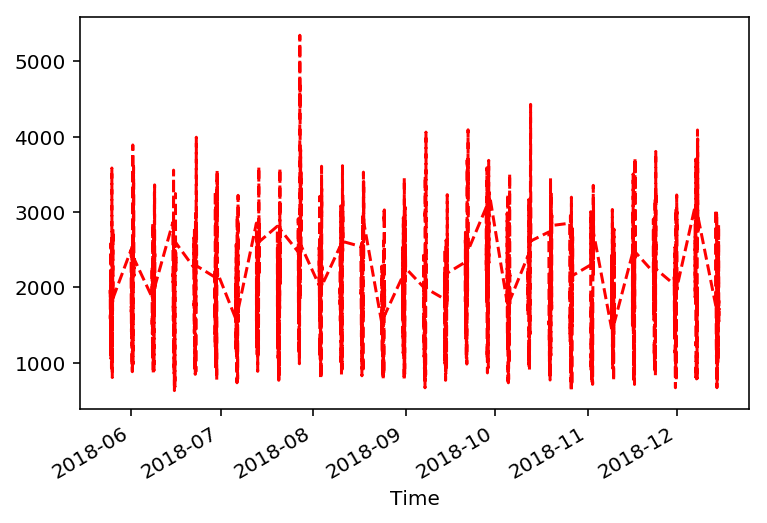

In [88]:
fit4.fittedvalues.plot(style='--', color='red')

In [89]:
forecast=fit4.forecast(96)
forecast
#forecast.plot(style='--', marker='o', color='red', legend=True)

C:\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:531: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


2880    1544.712683
2881    1552.586107
2882    1444.679779
2883    1364.255779
2884    1300.976859
2885    1301.922467
2886    1276.216196
2887    1259.196395
2888    1213.369031
2889    1174.836239
2890    1134.545369
2891    1156.686262
2892    1104.847103
2893    1135.671537
2894    1129.740862
2895    1058.704381
2896    1073.588567
2897    1070.266411
2898    1114.568678
2899    1450.478927
2900    1724.321661
2901    2113.517538
2902    1536.225222
2903    1023.177651
2904    1024.157240
2905    1745.273792
2906    1039.760272
2907     894.915916
2908     859.920444
2909     911.399965
2910     862.294786
2911     902.064017
2912     928.672524
2913     939.394005
2914     877.318944
2915     874.683197
2916     893.953642
2917     874.234092
2918     853.133833
2919     988.087262
2920     981.240814
2921    1226.339750
2922    1077.122040
2923    1216.164132
2924    1088.811723
2925    1040.459388
2926     945.548495
2927     956.786192
2928     932.334379
2929    1134.244579


In [90]:
compare=clean('Energy_Balance_'+predict_date)
compare

,Consumption
Time,
2018-12-21 00:15:00,1370
2018-12-21 00:30:00,1345
2018-12-21 00:45:00,1116
2018-12-21 01:00:00,1404
2018-12-21 01:15:00,1419
2018-12-21 01:30:00,1510
2018-12-21 01:45:00,1276
2018-12-21 02:00:00,1279
2018-12-21 02:15:00,1203


In [95]:
pmb=predict_month-1
if predict_day>1:
        db=(str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(predict_day-1).zfill(2))
else:
    if pmb==1 or pmb==3 or pmb==5 or pmb==7 or pmb==8 or pmb==10 or pmb==12:
        db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(31).zfill(2))
    elif pmb==4 or pmb==6 or pmb==9 or pmb==11:
        db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(30).zfill(2))
    else:
        if predict_year%4==0:
            db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(29).zfill(2))
        else:
            db=(str(predict_year)+'_'+str(pmb).zfill(2)+'_'+str(38).zfill(2))    
dayb=clean('Energy_Balance_'+db)
bf=clean('Energy_Balance_'+str(predict_year)+'_'+str(predict_month).zfill(2)+'_'+str(predict_day-1).zfill(2))
for i in range(compare.shape[0]):
    if compare.iloc[i,0]==0:
        compare.iloc[i,0]=dayb.iloc[i,0]


In [91]:
forecastcolumn=[]
for i in range(96):
    forecastcolumn.append(forecast.iloc[i])

In [92]:
compare['Forecast']=forecastcolumn

In [93]:
compare.rename(columns={'Consumption':'Real'},inplace=True)

In [94]:
compare

,Real,Forecast
Time,,
2018-12-21 00:15:00,1370,1544.712683
2018-12-21 00:30:00,1345,1552.586107
2018-12-21 00:45:00,1116,1444.679779
2018-12-21 01:00:00,1404,1364.255779
2018-12-21 01:15:00,1419,1300.976859
2018-12-21 01:30:00,1510,1301.922467
2018-12-21 01:45:00,1276,1276.216196
2018-12-21 02:00:00,1279,1259.196395
2018-12-21 02:15:00,1203,1213.369031


In [96]:
compare['Error']=compare['Real']-compare['Forecast']

In [97]:
compare['absError/Real']=abs(compare['Error'])/compare['Real']

In [98]:
compare

,Real,Forecast,Error,absError/Real
Time,,,,
2018-12-21 00:15:00,1370,1544.712683,-174.712683,0.127528
2018-12-21 00:30:00,1345,1552.586107,-207.586107,0.154339
2018-12-21 00:45:00,1116,1444.679779,-328.679779,0.294516
2018-12-21 01:00:00,1404,1364.255779,39.744221,0.028308
2018-12-21 01:15:00,1419,1300.976859,118.023141,0.083173
2018-12-21 01:30:00,1510,1301.922467,208.077533,0.137800
2018-12-21 01:45:00,1276,1276.216196,-0.216196,0.000169
2018-12-21 02:00:00,1279,1259.196395,19.803605,0.015484
2018-12-21 02:15:00,1203,1213.369031,-10.369031,0.008619


In [99]:
MAPE=compare['absError/Real'].sum()*100/96
MAPE

18.478142089686152

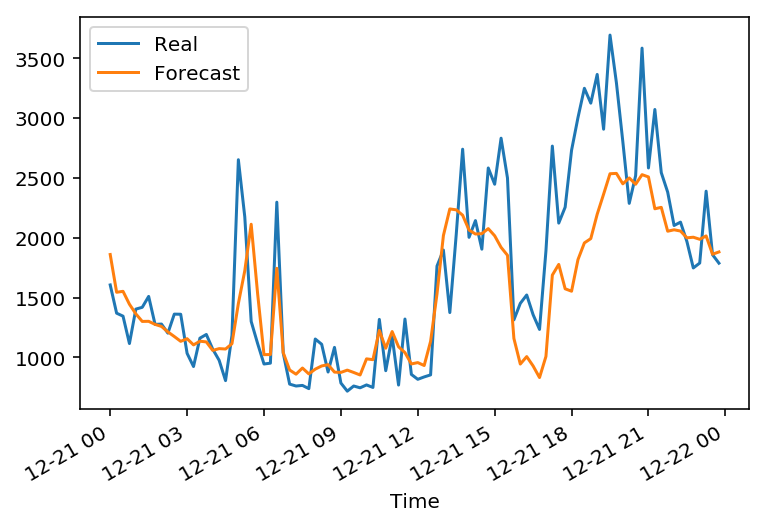

In [100]:
compare[['Real','Forecast']].plot(kind='line')

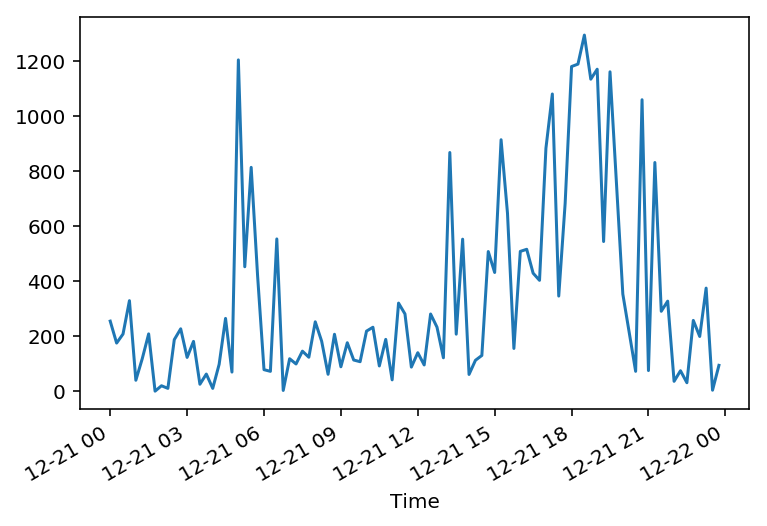

In [101]:
abs(compare.Error).plot(kind='line')

In [102]:
fit4.model.params

{'smoothing_level': 0.45601974382132443,
 'smoothing_slope': 4.582990207260137e-16,
 'smoothing_seasonal': 1.8725266623801597e-15,
 'damping_slope': nan,
 'initial_level': 2363.833238803385,
 'initial_slope': 3.0139803093446167,
 'initial_seasons': array([0.83023914, 0.83312129, 0.77396676, 0.72970249, 0.69473637,
        0.69412415, 0.67932714, 0.66919393, 0.64380797, 0.62236735,
        0.60006524, 0.61080196, 0.58250059, 0.597802  , 0.5937382 ,
        0.55552484, 0.56244538, 0.55982097, 0.58207637, 0.75631289,
        0.89768998, 1.09858341, 0.79726413, 0.53017543, 0.52985552,
        0.90152488, 0.53625549, 0.46083579, 0.44212871, 0.46787191,
        0.44197966, 0.46165068, 0.4745362 , 0.47927657, 0.44691878,
        0.44489302, 0.45399863, 0.44330541, 0.43194576, 0.49951108,
        0.49529531, 0.61807219, 0.54204345, 0.61108718, 0.546269  ,
        0.52122193, 0.47296186, 0.47786252, 0.46495027, 0.56479292,
        0.76147353, 1.0024816 , 1.11109852, 1.10578642, 1.08195158,
    